# Hierarchical Clustering

In [380]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from scipy.stats import mode
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.metrics import silhouette_score, davies_bouldin_score
import sys
sys.path.append('../')
from utils import center_and_scale
from matplotlib import pyplot as plt

## Cyclist Dataset

In [381]:
cyclist_df = pd.read_csv('../dataset/cyclists_outlier.csv')

### Preprocessing

In [382]:
column_to_drop = ["cyclist_win", "cyclist_experience", "avg_position", "best_position", "birth_year", 
                  "performance_entropy", "min_relative_position", "cyclist_win_ratio", "weighted_podiums", "best_position_std", "avg_performance_vs_startlist"]

# drop the unnecessary columns for the clustering and keep only the numerical columns
numerical_cyclists_df = cyclist_df.drop(columns=column_to_drop).select_dtypes(include=['float64', 'int64'])
numerical_cyclists_df

,avg_relative_position,relative_position_std,career_level
0,0.456286,0.243635,6267.25
1,0.630686,0.205735,117.25
2,0.557360,0.219011,1993.50
3,0.464642,0.238795,410.50
4,0.589817,0.238517,1874.10
...,...,...,...
4224,0.510309,0.340690,437.60
4225,0.637519,0.215697,32.60
4226,0.697735,0.150866,0.00
4227,0.413682,0.238513,1243.80


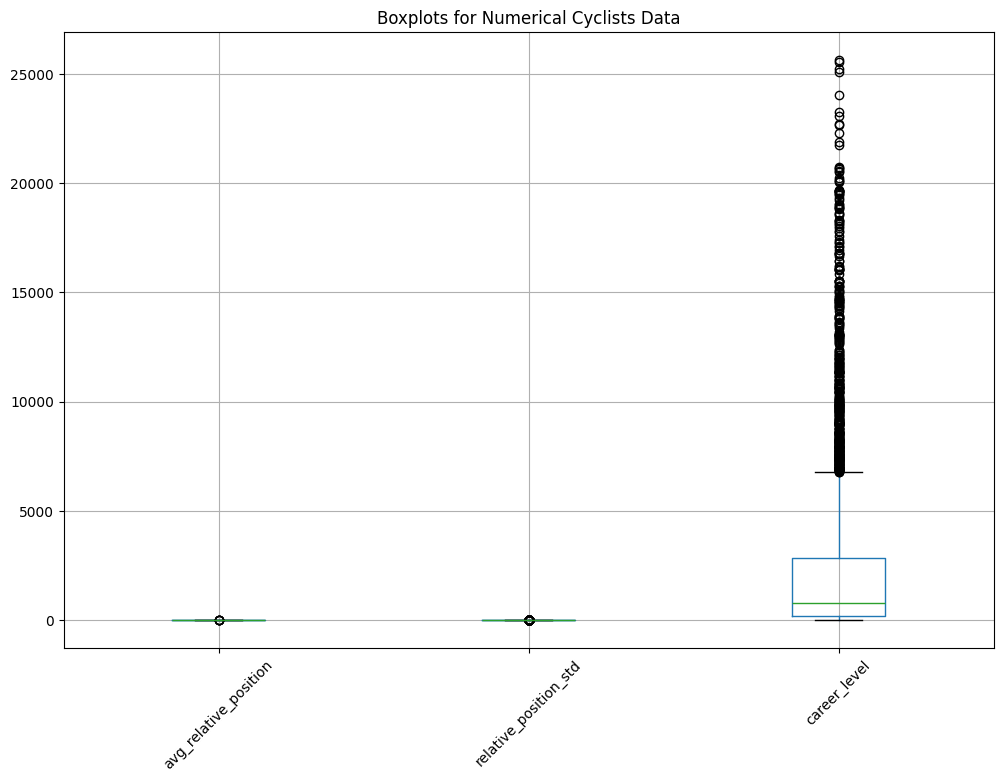

In [383]:
# Plot boxplots for numerical_cyclists_df
plt.figure(figsize=(12, 8))
numerical_cyclists_df.boxplot()
plt.title('Boxplots for Numerical Cyclists Data')
plt.xticks(rotation=45)
plt.show()

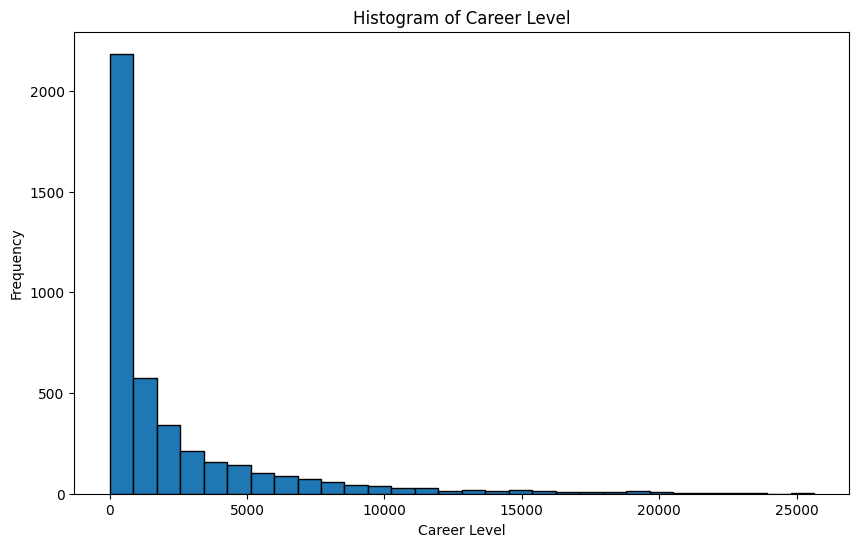

In [384]:
plt.figure(figsize=(10, 6))
plt.hist(cyclist_df['career_level'], bins=30, edgecolor='black')
plt.title('Histogram of Career Level')
plt.xlabel('Career Level')
plt.ylabel('Frequency')
plt.show()

We normalize the data.

In [385]:
scaler = StandardScaler()
scaler = scaler.fit(numerical_cyclists_df)
scaled_cyclists_df = scaler.transform(numerical_cyclists_df)

### Clustering 
We perform the agglomerative hirarchical clustering.

In [386]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.base import BaseEstimator, ClusterMixin
# from sklearn.metrics import silhouette_score, davies_bouldin_score

# class HierarchicalClustering(BaseEstimator, ClusterMixin):
#     def __init__(self, metric='euclidean', method='complete', n_clusters=10):
#         self.metric = metric
#         self.method = method
#         self.n_clusters = n_clusters

#     def fit(self, scaled_cyclists_df, y=None):
#         self.distance = pdist(scaled_cyclists_df, metric=self.metric)
#         self.linkage_matrix = linkage(self.distance, method=self.method)
#         self.labels_ = fcluster(self.linkage_matrix, self.n_clusters, criterion='maxclust')
#         return self

#     def fit_predict(self, scaled_cyclists_df, y=None):
#         self.fit(scaled_cyclists_df)
#         return self.labels_

# def scorer(estimator, scaled_cyclists_df):
#     labels = estimator.fit_predict(scaled_cyclists_df)
#     silhouette = silhouette_score(scaled_cyclists_df, labels)
#     return silhouette

# metrics = ['cityblock','correlation', 'cosine', 'euclidean']
# methods = ['complete','single','average','weighted']

# param_grid = {
#     'metric': metrics,
#     'n_clusters': [3, 4, 5, 10],
#     'method': [method for metric in metrics for method in (methods + ['ward', 'median', 'centroid'] if metric == 'euclidean' else methods)]
# }

# hc = HierarchicalClustering()
# grid_search = GridSearchCV(hc, param_grid=param_grid, scoring=scorer)
# grid_search.fit(scaled_cyclists_df)


In [387]:
# # Extract the best result
# best_result = grid_search.best_estimator_
# best_labels = best_result.fit_predict(scaled_cyclists_df)
# best_silhouette = scorer(best_result, scaled_cyclists_df)
# best_davies_bouldin = davies_bouldin_score(scaled_cyclists_df, best_labels)
# best_metric = best_result.metric

# print("Best result:")
# print(best_result)
# print(f"Best silhouette score: {best_silhouette}")
# print(f"Best Davies-Bouldin score: {best_davies_bouldin}")
# print(f"Metric used: {best_metric}")

In [388]:
# import numpy as np

# results_df = pd.DataFrame(grid_search.cv_results_['params'])
# results_df['silhouette_score'] = grid_search.cv_results_['mean_test_score']

# # Add a column for the number of elements in each cluster
# results_df['cluster_counts'] = results_df.apply(
#     lambda row: dict(zip(*np.unique(fcluster(linkage(pdist(scaled_cyclists_df, metric=row['metric']), method=row['method']), row['n_clusters'], criterion='maxclust'), return_counts=True))),
#     axis=1
# )

# results_df.sort_values(by='silhouette_score', ascending=False, inplace=True)
# results_df.head(10)

In [389]:
# # Plot the dendrogram for the best result
# plt.figure(figsize=(10, 7))
# dendrogram(best_result.linkage_matrix, truncate_mode='lastp', p=best_result.n_clusters)
# plt.title(f"Dendrogram (Best Result: metric: {best_metric}, method: {best_result.method}, clusters: {best_result.n_clusters})")
# plt.xlabel("Sample index")
# plt.ylabel("Distance")
# plt.show()

In [390]:
results = []
for metric in ['cityblock','correlation', 'cosine', 'euclidean']:
    methods = ['complete','single','average','weighted']
    if metric == 'euclidean':
        methods += ['ward','median','centroid']
    for method in methods:
        for k in [3, 4, 5, 6, 10]:
            distances = pdist(scaled_cyclists_df, metric=metric)
            dlinkage = linkage(distances, metric=metric, method=method)
            labels = fcluster(dlinkage,k,criterion='maxclust')
            silhouette = silhouette_score(scaled_cyclists_df, labels)
            bouldin = davies_bouldin_score(scaled_cyclists_df, labels)
            #print(f"metric: {metric}, method:{method}, level':{level}, k:{k}, silhouette: {silhouette} , DBscore:{bouldin}")
            results.append({'metric':metric, 'method':method, 'k':k, 'silhouette': silhouette, 'DBscore':bouldin})

results_df = pd.DataFrame(results)

In [391]:
# Order the results by the best silhouette score and then by the highest DB score if silhouette scores are the same
results_df.sort_values(by=['silhouette', 'DBscore'], ascending=[False, True], inplace=True)


# show results
results_df.head(20)


,metric,method,k,silhouette,DBscore
90,euclidean,centroid,3,0.360184,0.891483
70,euclidean,average,3,0.344049,0.770496
10,cityblock,average,3,0.343110,0.794722
15,cityblock,weighted,3,0.334881,0.643604
11,cityblock,average,4,0.331151,0.673852
80,euclidean,ward,3,0.329355,0.956767
60,euclidean,complete,3,0.327068,0.813463
65,euclidean,single,3,0.310773,0.416467
85,euclidean,median,3,0.307892,0.750388
71,euclidean,average,4,0.299485,0.856846


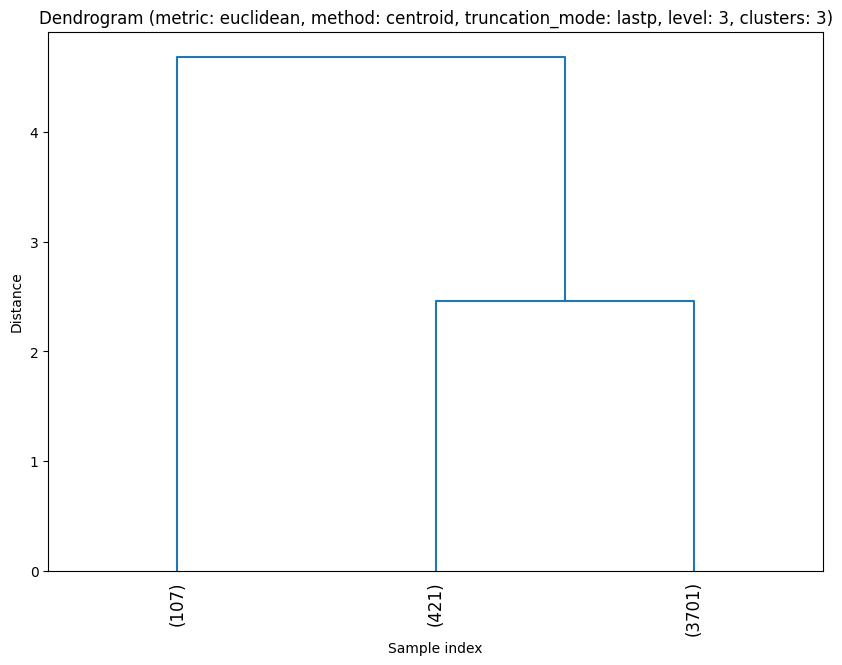

In [392]:
# Extract the first row's linkage matrix
first_row = results_df.iloc[0]
metric = first_row['metric']
method = str(first_row['method'])  # Ensure method is a string
truncation_mode = 'lastp'
k = first_row['k']
level = first_row['k']

# Compute the distances and linkage matrix again for the first row
distances = pdist(scaled_cyclists_df, metric=metric)
dlinkage = linkage(distances, method=method)

# Calculate the color threshold to match the number of clusters
color_threshold = dlinkage[-k, 2]

# Get the cluster labels
labels = fcluster(dlinkage, k, criterion='maxclust')

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(dlinkage, truncate_mode=truncation_mode, p=int(level), leaf_rotation=90, color_threshold=color_threshold)  # Ensure level is an integer
plt.title(f"Dendrogram (metric: {metric}, method: {method}, truncation_mode: {truncation_mode}, level: {level}, clusters: {k})")
plt.xlabel("Sample index")
plt.ylabel("Distance")
plt.show()

In [393]:
# metric = 'euclidean'
# method = 'centroid'  # Ensure method is a string
# truncation_mode = 'lastp'
# k = 8
# level = 10

# # Compute the distances and linkage matrix again for the first row
# distances = pdist(scaled_cyclists_df, metric=metric)
# dlinkage = linkage(distances, method=method)

# # Calculate the color threshold to match the number of clusters
# color_threshold = dlinkage[-k, 2]

# # Get the cluster labels
# labels = fcluster(dlinkage, k, criterion='maxclust')

# # Plot the dendrogram
# plt.figure(figsize=(10, 7))
# dendrogram(dlinkage, truncate_mode=truncation_mode, p=int(level), leaf_rotation=90, color_threshold=color_threshold)  # Ensure level is an integer
# plt.title(f"Dendrogram (metric: {metric}, method: {method}, truncation_mode: {truncation_mode}, level: {level}, clusters: {k})")
# plt.xlabel("Sample index")
# plt.ylabel("Distance")
# plt.show()



In [394]:
silhouette = silhouette_score(scaled_cyclists_df, labels)
bouldin = davies_bouldin_score(scaled_cyclists_df, labels)
print(f"metric: {metric}, method:{method}, level':{level}, k:{k}, silhouette: {silhouette} , DBscore:{bouldin}")

metric: euclidean, method:centroid, level':3, k:3, silhouette: 0.3601836365016366 , DBscore:0.8914830947941769


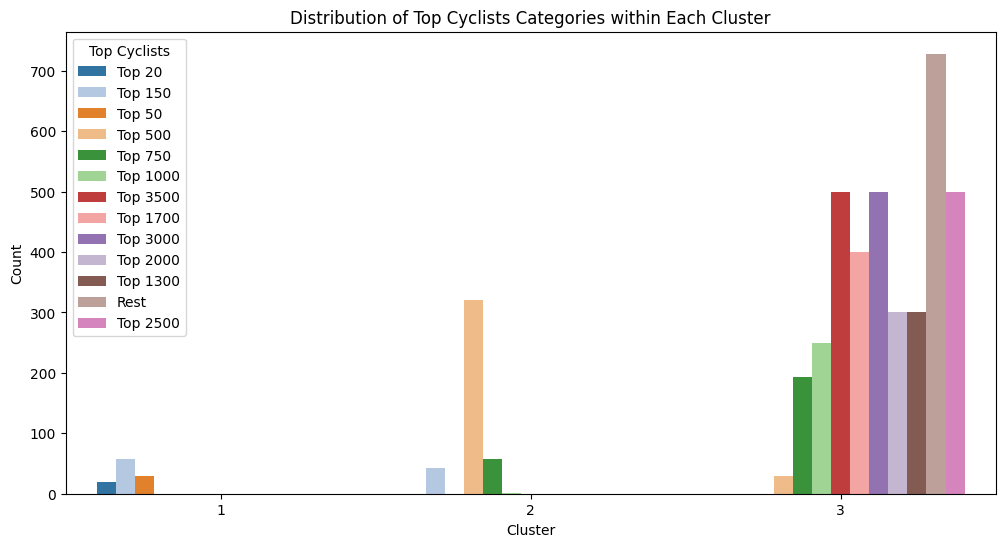

In [395]:
import seaborn as sns

# Add the cluster labels to the original dataframe
cyclist_df['Cluster'] = labels

# Plot the count plot
plt.figure(figsize=(12, 6))
sns.countplot(data=cyclist_df, x='Cluster', hue='top_cyclists', palette='tab20')
plt.title('Distribution of Top Cyclists Categories within Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.legend(title='Top Cyclists')
plt.show()

In [396]:
# Define the color mapping
color_mapping = {
    'Top 20': '#006400',  # Dark Green
    'Top 50': '#228B22',  # Forest Green
    'Top 150': '#32CD32',  # Lime Green
    'Top 500': '#7CFC00',  # Lawn Green
    'Top 750': '#FF8C00',  # Dark Orange
    'Top 1000': '#FFA500',  # Orange
    'Top 1300': '#FFD700',  # Gold
    'Top 1700': '#FFE4B5',  # Moccasin
    'Top 2000': '#8B0000',  # Dark Red
    'Top 2500': '#B22222',  # Firebrick
    'Top 3000': '#DC143C',  # Crimson
    'Top 3500': '#FF6347',  # Tomato
    'Rest': '#808080'  # Grey
}


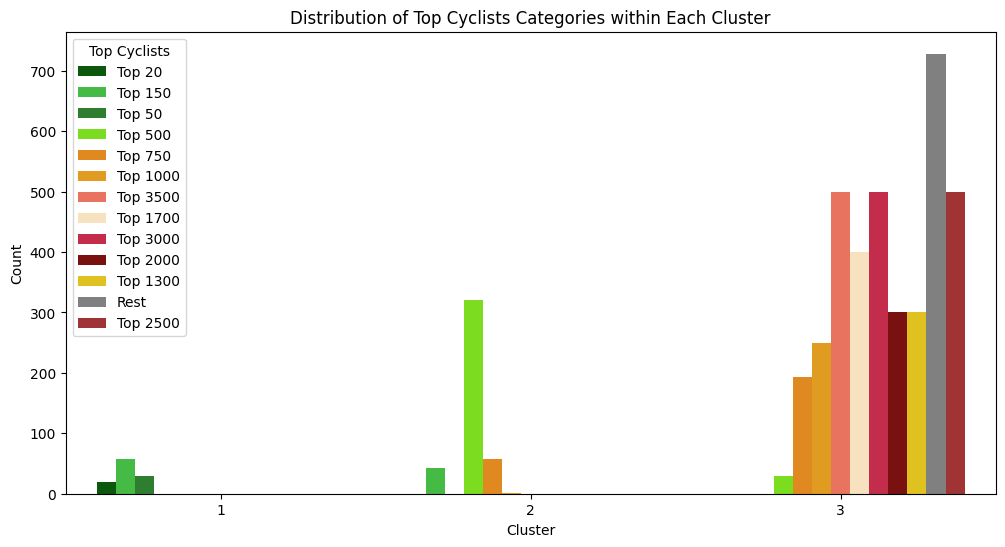

In [397]:
import seaborn as sns

# Add the cluster labels to the original dataframe
cyclist_df['Cluster'] = labels

# Plot the count plot with the defined colors
plt.figure(figsize=(12, 6))
sns.countplot(data=cyclist_df, x='Cluster', hue='top_cyclists', palette=color_mapping)
plt.title('Distribution of Top Cyclists Categories within Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.legend(title='Top Cyclists')
plt.show()

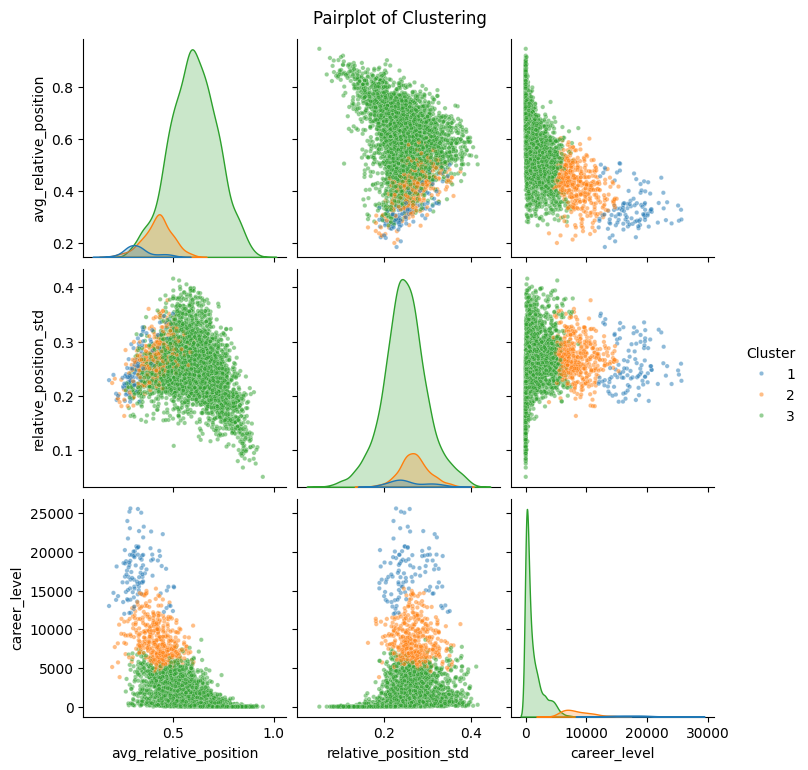

In [398]:
# Select a subset of columns for the pairplot
subset_columns = ['avg_relative_position', 'relative_position_std', 'career_level', 'Cluster']

# Create the pairplot
sns.pairplot(cyclist_df[subset_columns], hue='Cluster', palette='tab10', plot_kws={'alpha': 0.5, 's':10})
plt.suptitle('Pairplot of Clustering', y=1.02)
plt.show()